# Xử lý dữ liệu SPADE


In [1]:
import pandas as pd
import numpy as np
import hashlib
import networkx as nx
from collections import Counter, deque
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
import random as rd
import json
import lmstudio as lms
import seaborn as sns

## Tiền xử lý


## Chuyển file đã tiền xử lý sang dạng để sử dụng cho WL subtree

In [2]:

edges = 0
nodes = 0
def build_graph_from_spade(events, _label = "benign"):
    G = nx.DiGraph()
    global nodes
    global edges
    for entry in events:
        if 'id' in entry:  # là một node
            node_id = entry['id']
            node_type = entry['type']
            label = entry.get('annotations', {}).get('subtype', node_type)
            G.add_node(node_id, label=label)
            nodes += 1
        else:  # là một edge
            src = entry['from']
            dst = entry['to']
            label = entry['annotations'].get("operation", entry["type"])
            G.add_edge(src, dst, label=label)
            label = _label
            edges += 1
    labels.append(label)
    return G
file_name = "../../dataset/SPADE/benign_small.json"
with open(file_name, "r", encoding="utf-8") as f:
    logs = json.load(f)
labels = []
label = ""
graphs = []

for log in tqdm(logs, desc="Graphs"):
    if(len(log) > 0):
        graphs.append(build_graph_from_spade(log, _label = "benign"))

print(f"nodes: {nodes//len(graphs)}, edges: {edges//len(graphs)}")

Graphs: 100%|██████████| 1500/1500 [00:02<00:00, 559.26it/s] 

nodes: 349, edges: 648


In [3]:
edges = 0
nodes = 0
def build_graph_from_spade(events, _label = "benign"):
    G = nx.DiGraph()
    global nodes
    global edges
    for entry in events:
        if 'id' in entry:  # là một node
            node_id = entry['id']
            node_type = entry['type']
            label = entry.get('annotations', {}).get('subtype', node_type)
            G.add_node(node_id, label=label)
            nodes += 1
        else:  # là một edge
            src = entry['from']
            dst = entry['to']
            label = entry['annotations'].get("operation", entry["type"])
            G.add_edge(src, dst, label=label)
            label = _label
            edges += 1
    labels.append(label)
    return G
file_name = "../../dataset/SPADE/malware4_cleaned.json"
with open(file_name, "r", encoding="utf-8") as f:
    logs = json.load(f)

file_name = "../../dataset/SPADE/benign_small.json"
for log in tqdm(logs, desc="Graphs"):
    if(len(log) > 0):
        graphs.append(build_graph_from_spade(log, _label = "attack"))
print(f"nodes: {nodes//150}, edges: {edges//150}")

Graphs: 100%|██████████| 150/150 [00:00<00:00, 283.71it/s]

nodes: 772, edges: 1172


In [4]:
print(len(labels))

1650


## FlexSketch
Được trình bày trong bài báo [FlexSketch: Estimation of Probability Density for Stationary and Non-Stationary Data Streams](https://doi.org/10.3390/s21041080).

FlexSketch được sử dụng

In [5]:
class FlexSketch:
    def __init__(self, max_bins=100, max_histograms=5):
        self.max_bins = max_bins
        self.max_histograms = max_histograms
        self.histograms = deque()
        self.weights = deque()

    def update(self, label_counter):
        most_common = label_counter.most_common(self.max_bins)
        vector = np.zeros(self.max_bins)
        for i, (_, count) in enumerate(most_common):
            vector[i] = count
        self.histograms.append(vector)
        self.weights.append(1.0)
        if len(self.histograms) > self.max_histograms:
            self.histograms.popleft()
            self.weights.popleft()
        total_weight = sum(self.weights)
        self.weights = deque([w / total_weight for w in self.weights])

    def estimate_vector(self):
        result = np.zeros(self.max_bins)
        for h, w in zip(self.histograms, self.weights):
            result += w * h
        return result

# WL subtree extraction
def wl_subtree_features(graph, k=2):
    node_labels = nx.get_node_attributes(graph, 'label')
    features = {node: [node_labels.get(node, 'N/A')] for node in graph.nodes()}
    current_labels = node_labels.copy()
    for _ in range(k):
        new_labels = {}
        for node in graph.nodes():
            neighbors = sorted(
                [str(current_labels.get(nbr, '')) for nbr in graph.predecessors(node)] +
                [str(current_labels.get(nbr, '')) for nbr in graph.successors(node)]
            )
            combined = str(current_labels.get(node, '')) + "|" + "|".join(neighbors)
            hash_label = hashlib.md5(combined.encode()).hexdigest()
            new_labels[node] = hash_label
            features[node].append(hash_label)
        current_labels = new_labels
    return features

In [6]:
print("Extracting FlexSketch vectors...")
flex_vectors = []
sketch = FlexSketch(max_bins=100)
for G in tqdm(graphs, desc="Vectorizing"):
    wl_feats = wl_subtree_features(G, k=3)
    all_labels = []
    for lbls in wl_feats.values():
        all_labels.extend(lbls)
    sketch.update(Counter(all_labels))
    flex_vectors.append(sketch.estimate_vector())



Extracting FlexSketch vectors...


Vectorizing: 100%|██████████| 1650/1650 [00:03<00:00, 457.42it/s]


Splitting benign and attack samples...
Standardizing feature vectors...
Training KMeans on benign samples...
Computing anomaly threshold...


Benign distances: 100%|██████████| 1500/1500 [00:00<00:00, 159438.82it/s]


Predicting anomalies...


Predicting: 100%|██████████| 1650/1650 [00:00<00:00, 154722.92it/s]

Evaluating...
        precision  recall  f1-score
Benign   1.000000   0.968  0.983740
Attack   0.757576   1.000  0.862069


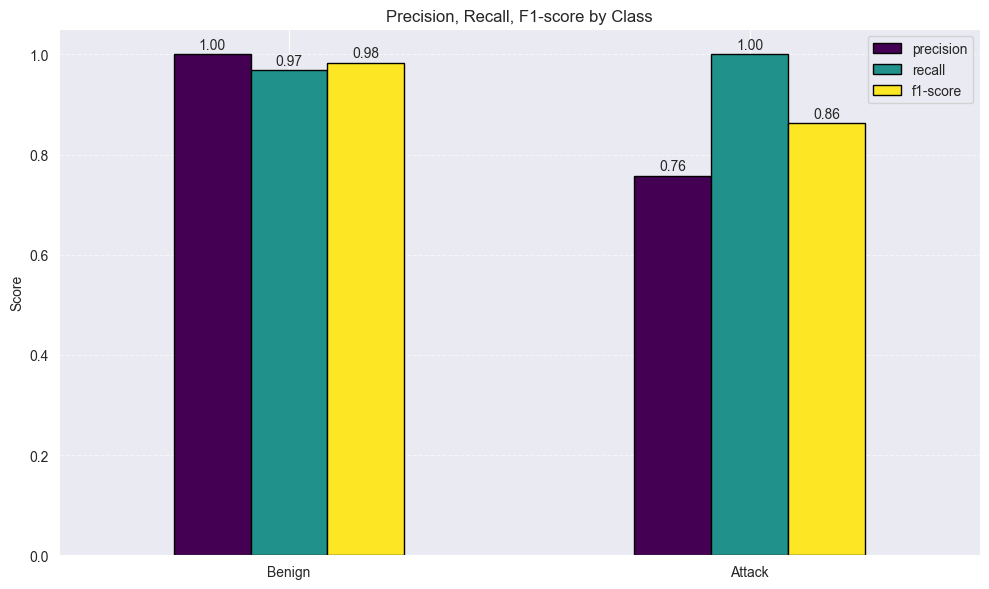

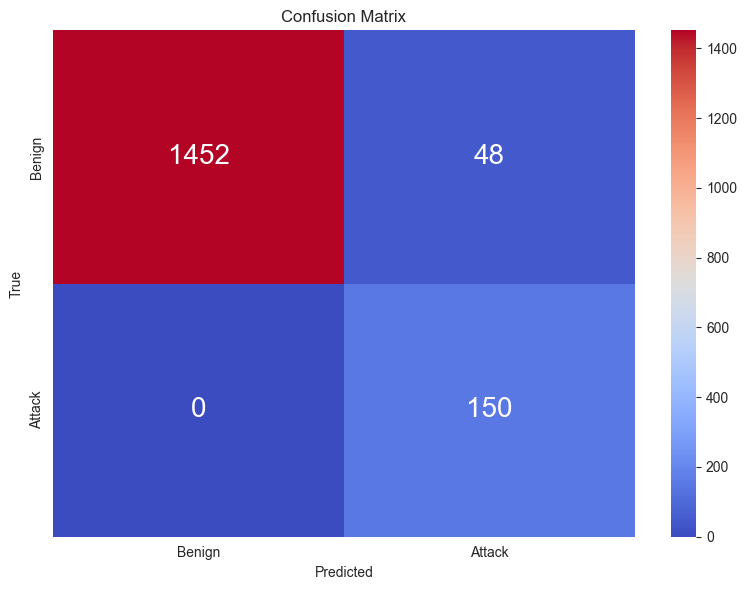


=== Classification Report (Anomaly Detection) ===
{'Benign': {'precision': 1.0, 'recall': 0.968, 'f1-score': 0.983739837398374, 'support': 1500.0}, 'Attack': {'precision': 0.7575757575757576, 'recall': 1.0, 'f1-score': 0.8620689655172413, 'support': 150.0}, 'accuracy': 0.9709090909090909, 'macro avg': {'precision': 0.8787878787878788, 'recall': 0.984, 'f1-score': 0.9229044014578076, 'support': 1650.0}, 'weighted avg': {'precision': 0.9779614325068872, 'recall': 0.9709090909090909, 'f1-score': 0.9726788490455439, 'support': 1650.0}}


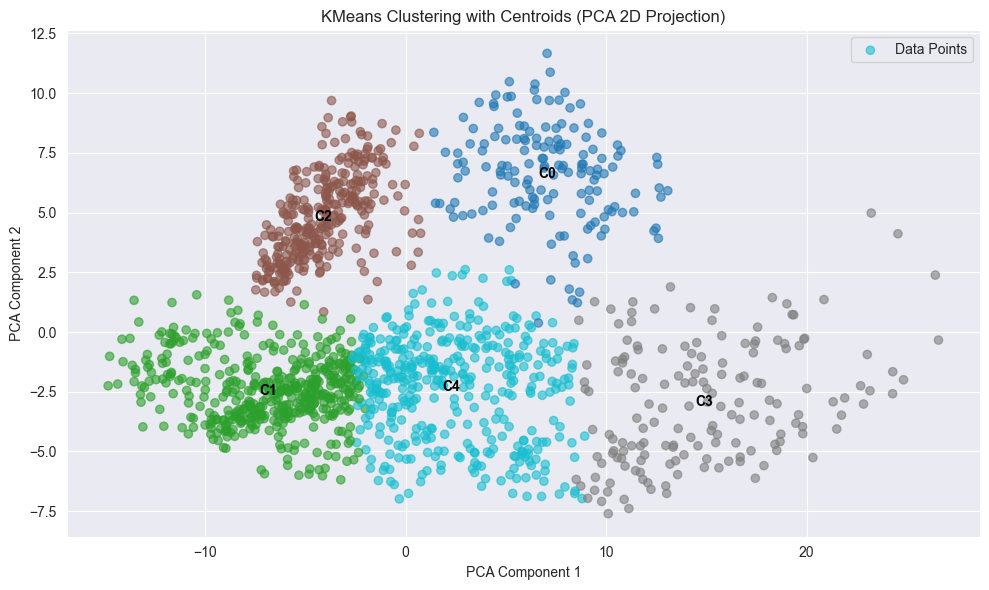

In [7]:
import random

X = np.array(flex_vectors)
y = np.array(labels)

print("Splitting benign and attack samples...")
X_benign = X[y == "benign"]
X_attack = X[y == "attack"] #mo cmt khi co attack
# X_attack = rd.choices(X_attack, k = 50)
# y_attack = ["attack"] * 50

X = np.concatenate([X_benign, X_attack], axis=0) # mo cmt khi co attack
# X = np.concatenate([X_benign], axis=0) # cmt khi chi co benign
# y = ["benign"] * len(labels) + ["attack"] * 50
y = labels
print("Standardizing feature vectors...")
scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)
X_attack_scaled = scaler.transform(X_attack)
X_all_scaled = scaler.transform(X)

print("Training KMeans on benign samples...")
kmeans = KMeans(n_clusters=5, random_state=random.randint(1,100))
kmeans.fit(X_benign_scaled)

def min_distance(x):
    return np.min(np.linalg.norm(kmeans.cluster_centers_ - x, axis=1))

print("Computing anomaly threshold...")
benign_dists = [min_distance(x) for x in tqdm(X_benign_scaled, desc="Benign distances")]
threshold = np.percentile(benign_dists, 96.8)

with open("../../model/SPADE/threshold_spade.json", "w") as f:
    json.dump({"threshold": threshold}, f)

print("Predicting anomalies...")
all_labels = [1 if cls == "attack" else 0 for cls in y]
pred_labels = [1 if min_distance(x) > threshold else 0 for x in tqdm(X_all_scaled, desc="Predicting")]

print("Evaluating...")

report = classification_report(all_labels, pred_labels, target_names=["Benign", "Attack"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Filter only Benign, Attack
plot_data = df_report.loc[["Benign", "Attack"], ["precision", "recall", "f1-score"]]
print(plot_data)

# Plot
ax = plot_data.plot(kind="bar", figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

# Thêm số trên cột
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2)

plt.show()


cm = confusion_matrix(all_labels, pred_labels)
plt.figure(figsize=(8, 6))
colormap = sns.color_palette("coolwarm", 500, as_cmap=True)
sns.heatmap(cm, annot=True, fmt='d', cmap=colormap, xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"], annot_kws={"size": 20})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

model_path = "../../model/SPADE/kmeans_model_spade.joblib"
scaler_path = "../../model/SPADE/scaler_spade.joblib"

joblib.dump(kmeans, model_path)
joblib.dump(scaler, scaler_path)

print("\n=== Classification Report (Anomaly Detection) ===")
print(report)
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_benign_scaled)
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Predict cluster labels for visualization
cluster_labels = kmeans.predict(X_benign_scaled)

# Plot clusters with centroids
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6, label="Data Points")
#plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='yellow', marker='X', s=200, edgecolor='black', label="Centroids")

# Annotate centroids
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f'C{i}', fontsize=10, ha='center', va='center', weight='bold', color='black')

plt.title("KMeans Clustering with Centroids (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Splitting benign and attack samples...
Standardizing feature vectors...


Threshold: 100%|██████████| 1001/1001 [00:44<00:00, 22.70it/s]


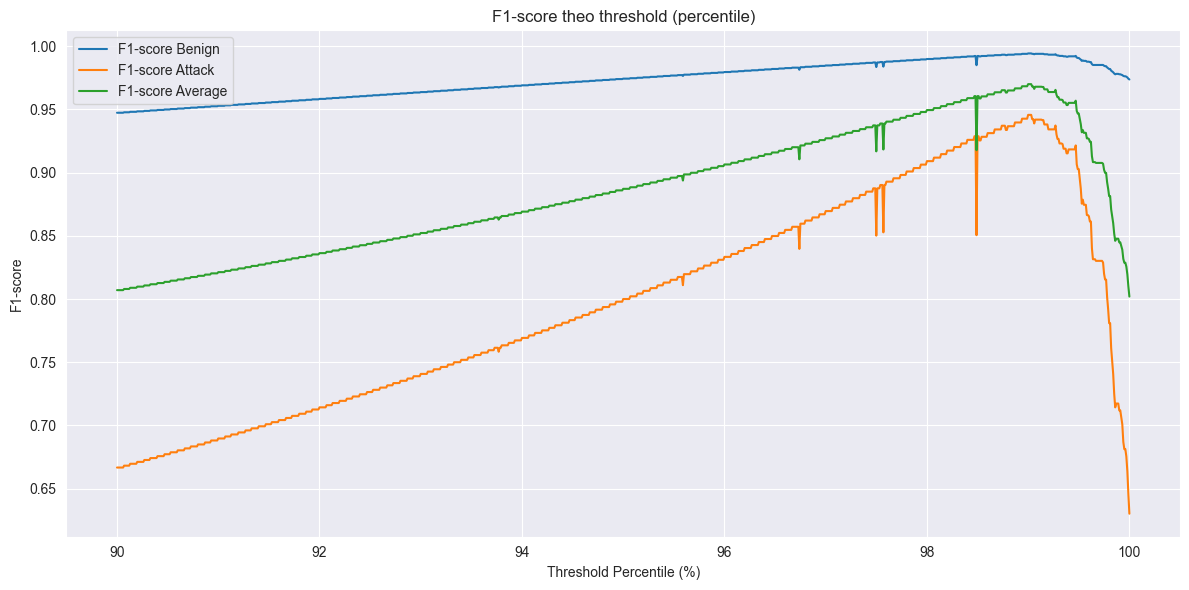

{'f1': np.float64(0.9699977859328657), 'threshold': 99.0}


In [8]:
import random

X = np.array(flex_vectors)
y = np.array(labels)

print("Splitting benign and attack samples...")
X_benign = X[y == "benign"]
X_attack = X[y == "attack"] #mo cmt khi co attack
# X_attack = rd.choices(X_attack, k = 50)
# y_attack = ["attack"] * 50

X = np.concatenate([X_benign, X_attack], axis=0) # mo cmt khi co attack
# X = np.concatenate([X_benign], axis=0) # cmt khi chi co benign
# y = ["benign"] * len(labels) + ["attack"] * 50
y = labels
print("Standardizing feature vectors...")
scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)
X_attack_scaled = scaler.transform(X_attack)
X_all_scaled = scaler.transform(X)

def min_distance(x):
    return np.min(np.linalg.norm(kmeans.cluster_centers_ - x, axis=1))

# print("Computing anomaly threshold...")

best = {
    "f1": 0,
    "threshold": 0,
}
results = []  # lưu toàn bộ kết quả

for thresh in tqdm(range(0, 1001), desc="Threshold"):
    # print("Training KMeans on benign samples...")
    kmeans = KMeans(n_clusters=5, random_state=random.randint(1,100))
    kmeans.fit(X_benign_scaled)



    benign_dists = [min_distance(x) for x in X_benign_scaled]
    threshold = np.percentile(benign_dists, 90 + (thresh * 0.01))
    
    # with open("../../model/SPADE/threshold_spade.json", "w") as f:
    #     json.dump({"threshold": threshold}, f)
    
    # print("Predicting anomalies...")
    all_labels = [1 if cls == "attack" else 0 for cls in y]
    pred_labels = [1 if min_distance(x) > threshold else 0 for x in X_all_scaled]
    
    # print("Evaluating...")
    
    report = classification_report(all_labels, pred_labels, target_names=["Benign", "Attack"], output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    
    # Filter only Benign, Attack
    plot_data = df_report.loc[["Benign", "Attack"], ["precision", "recall", "f1-score"]]
    results.append({
        "threshold_percentile": 90 + (thresh * 0.01),
        "threshold_value": threshold,
        "precision_benign": df_report.loc["Benign", "precision"],
        "recall_benign": df_report.loc["Benign", "recall"],
        "f1_benign": df_report.loc["Benign", "f1-score"],
        "precision_attack": df_report.loc["Attack", "precision"],
        "recall_attack": df_report.loc["Attack", "recall"],
        "f1_attack": df_report.loc["Attack", "f1-score"],
        "f1_average": (df_report.loc["Benign", "f1-score"] + df_report.loc["Attack", "f1-score"]) / 2,
    })

    if results[-1]["f1_average"] > best["f1"]:
        best["f1"] = results[-1]["f1_average"]
        best["threshold"] = 90 + (thresh * 0.01)


    # print(plot_data)
df_results = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
plt.plot(df_results["threshold_percentile"], df_results["f1_benign"], label="F1-score Benign")
plt.plot(df_results["threshold_percentile"], df_results["f1_attack"], label="F1-score Attack")
plt.plot(df_results["threshold_percentile"], df_results["f1_average"], label="F1-score Average")
plt.xlabel("Threshold Percentile (%)")
plt.ylabel("F1-score")
plt.title("F1-score theo threshold (percentile)")
plt.grid(True, linestyle="-", alpha=1)
plt.legend()
plt.tight_layout()
plt.show()

print(best)

## Thử nghiệm trên input thực tế

In [9]:

print(threshold)

total = 0
dis = []
idx = []
index = 0
def detect(x):
    global total
    dist = min_distance(x)
    # if dist > dis[0]:
    #     dis[1] = dis[0]
    #     idx[1] = idx[0]
    #     dis[0] = dist
    #     idx[0] = index
    # elif dist > dis[1]:
    #     dis[1] = dist
    #     idx[1] = index
    print(dist)
    # total += dist
    # if dist > threshold:
    dis.append([dist, index])
    return dist > threshold


for G in X_attack_scaled:
    if detect(G):
        print("attack")
    else:
        print("benign")
    index += 1

dis_sort = sorted(dis, key=lambda x: (x[0], x[1]), reverse=True)
print([_ for x, _ in dis_sort][0:150])

16.940552113084017
389.66360384201954
attack
309.36617349920346
attack
207.64774551072173
attack
101.94134700751356
attack
103.85559521294445
attack
67.25733817645452
attack
112.6319248664433
attack
79.05883469699391
attack
49.86322933437437
attack
23.065638823493586
attack
13.295958096688647
benign
16.775055471414053
benign
21.09541769634368
attack
22.637509494679545
attack
23.74233632322034
attack
49.14458131301904
attack
42.98273024414563
attack
24.293015831164404
attack
16.84467150417456
benign
16.331529314133718
benign
16.579959066994952
benign
14.451858982228176
benign
12.265762209462027
benign
11.599756525092085
benign
11.278448312663064
benign
15.772523878589098
benign
15.762037596523028
benign
13.526089885088616
benign
12.619443574786608
benign
43.620339089544935
attack
17.926000708124327
attack
39.317928369493345
attack
15.618226016482899
benign
54.99026156215732
attack
34.16166917032467
attack
16.01926511260325
benign
12.265276629834334
benign
14.2514213817317
benign
12.6619